In [1]:
import signatureanalyzer as sa

In [2]:
import numpy as np
import pandas as pd

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import random
import string
import subprocess
import anndata as an
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
import warnings
from collections import Counter

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.19.5 scipy==1.7.0 pandas==1.3.4 scikit-learn==1.0 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4


In [7]:
import signatureanalyzer as sa
import numpy as np
import pandas as pd
def annotate_adata_sigs(adata,res):
    W = res['W']
    H = res['H']

    Sidx = W.columns[W.columns.str.match('S\d+')]

    # Resort signatures
    sort_idx = H[Sidx].sum().sort_values(ascending=False).index

    H = H[sort_idx]
    H.columns=Sidx
    W = W[sort_idx]
    W.columns=Sidx


    W['max'] = W[Sidx].max(axis=1)
    W['max_id'] = np.argmax(W[Sidx].values,axis=1)

    norm_factor=1e3
    Sidx = W.columns[W.columns.str.match('S\d+')]

    adata.obs[Sidx]=norm_factor*H[Sidx]/adata.obs['total_counts'].values.reshape(-1,1)

    adata.obs['log'+Sidx] = np.log10(adata.obs[Sidx]+1)

    return(adata,W,H)

def get_ranking_matrix(W,H):
    Sidx = W.columns[W.columns.str.match('S\d+')]
    UE = W[Sidx]*H[Sidx].sum()
    FE = (UE.T/UE.T.sum()).T
    R=W[Sidx]*FE

    return(R)

def identify_sig_markers(W,R,sig,max_genes=5):
    
    max_genes = 5
    cumulative_thresh = .95 # Stop including markers if we've expained 90% of UMIs
    
    genes_sorted = R[sig].sort_values(ascending=False).index[0:max_genes]
        
    idx = np.hstack([0,W.loc[genes_sorted,sig].cumsum()[0:-1]])<cumulative_thresh
        
    genes_sorted=genes_sorted[idx]
    
    return genes_sorted

def identify_markers(W,H,max_genes=5):
    Sidx = W.columns[W.columns.str.match('S\d+')]
    R = get_ranking_matrix(W,H)
    sig_markers = [",".join(identify_sig_markers(W,R,sig)).strip(",") for sig in Sidx]
    S = pd.DataFrame({'id':Sidx,'markers':sig_markers}).set_index('id')
    return(S)
def get_ranking_matrix(W,H):
    
    Sidx = W.columns[W.columns.str.match('S\d+')]
    UE = W[Sidx]*H[Sidx].sum()
    FE = (UE.T/UE.T.sum()).T
    R=W[Sidx]*FE

    return(R)

def identify_sig_markers(W,R,sig,max_genes=5):
    
    max_genes = 5
    cumulative_thresh = .95 # Stop including markers if we've expained 90% of UMIs
    
    genes_sorted = R[sig].sort_values(ascending=False).index[0:max_genes]
        
    idx = np.hstack([0,W.loc[genes_sorted,sig].cumsum()[0:-1]])<cumulative_thresh
        
    genes_sorted=genes_sorted[idx]
    
    return genes_sorted

def identify_markers(W,H,max_genes=5):
    Sidx = W.columns[W.columns.str.match('S\d+')]
    R = get_ranking_matrix(W,H)
    sig_markers = [",".join(identify_sig_markers(W,R,sig)).strip(",") for sig in Sidx]
    S=pd.DataFrame({'id':Sidx,'markers':sig_markers}).set_index('id')
    return(S)


In [4]:
umi_process = sc.read_h5ad('/mnt/ccle_umi_process.h5ad')

In [18]:
umi_process[umi_process.obs['CCLE_ID'] == "NCIH1568_LUNG"]

View of AnnData object with n_obs × n_vars = 287 × 3852
    obs: 'Barcode', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'CCLE_ID', 'index.1', 'cancer_type', 'pool_id', 'n_cells', 'cancer_type_trunc'
    var: 'Unnamed: 0', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    layers: 'umi'

In [94]:
subtype = umi_process[umi_process.obs['CCLE_ID'] == "NCIH1568_LUNG"]

In [20]:
X = pd.DataFrame(subtype.layers['umi'].todense().T,
                 index=list(subtype.var.index),
                 columns=list(subtype.obs.index))

In [26]:
res = sa.ardnmf(X ,
                K0=10,
                tolerance=1e-5, 
                prior_on_W='L2',
                prior_on_H='L2', 
                max_iter = 10000)

adata, W, H = annotate_adata_sigs(subtype, res)
objective = res['objective']

NMF class initalized.
NMF data and parameters set.
   * Using CPU
%%%%%%%%%%%%%%%
a = 10.0
b = 0.2922069998824365
%%%%%%%%%%%%%%%
nit=    0 K=   10 | obj=239465.09	b_div=249912.73	lam=2.07	del=0.99995369	sumW=10310.03	sumH=414.79
nit=  100 K=    3 | obj=17778.98	b_div=123945.69	lam=0.28	del=0.00263057	sumW=1057.72	sumH=532.60
nit=  200 K=    3 | obj=16501.27	b_div=122762.84	lam=0.29	del=0.00268215	sumW=1051.79	sumH=520.38
nit=  300 K=    3 | obj=16110.20	b_div=122833.71	lam=0.29	del=0.00441792	sumW=1022.84	sumH=508.68
nit=  400 K=    3 | obj=15824.35	b_div=123206.35	lam=0.29	del=0.00494558	sumW=981.79	sumH=494.67
nit=  500 K=    3 | obj=15599.35	b_div=123926.59	lam=0.28	del=0.00862967	sumW=940.22	sumH=476.91
nit=  600 K=    3 | obj=10179.71	b_div=126969.72	lam=0.27	del=0.00119044	sumW=816.05	sumH=424.46
nit=  700 K=    3 | obj=9386.74	b_div=126389.56	lam=0.27	del=0.00007250	sumW=813.39	sumH=422.76
nit=  800 K=    3 | obj=9318.07	b_div=126326.12	lam=0.27	del=0.00022073	sumW=815.90	sumH=

Clusters: 100%|██████████| 3/3 [00:00<00:00, 111.32it/s]


In [55]:
Sidx = W.columns[W.columns.str.match('S\d+')]
sort_idx = H[Sidx].sum().sort_values(ascending=False).index
H = H[sort_idx]
H.columns=Sidx
W = W[sort_idx]
W.columns=Sidx
W['max'] = W[Sidx].max(axis=1)
W['max_id'] = np.argmax(W[Sidx].values,axis=1)+1

S = identify_markers(W, H, max_genes = 5)

H_rate = H.div(subtype.obs['total_counts'], axis = 0)*10**3
H_log_rate = np.log10(H_rate[Sidx]+1)
H_log_rate = H_log_rate.add_prefix("log")
H_rate_concat = pd.concat([H_rate, subtype.obs], axis = 1)
full_R = get_ranking_matrix(W,H)

In [95]:
sc.tl.pca(subtype)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


In [96]:
for i in range(S.shape[0]):
    print(i)
    subtype.obs[f'S{i+1}'] = H_rate[f'S{i+1}']

0
1
2


In [58]:
S

,markers
id,
S1,"KRT8,S100A10,S100A11,IGFBP3,EFNA1"
S2,"DMKN,FERMT1,OCIAD2,TACSTD2,VIM"
S3,"SGIP1,CD248,PTGER4,FRMD3,ASGR1"


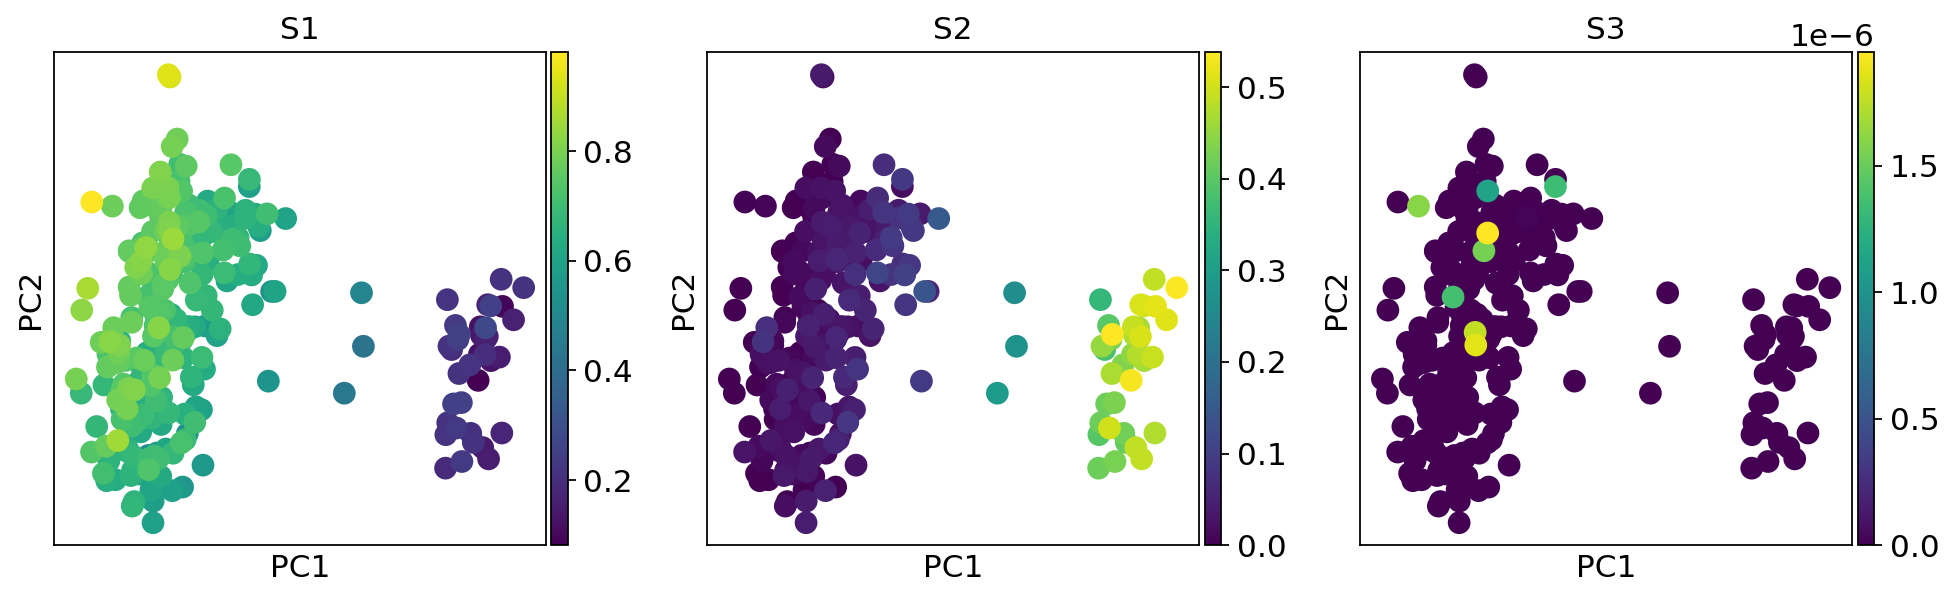

In [59]:
sc.pl.pca(subtype, color = ['S1','S2','S3'])

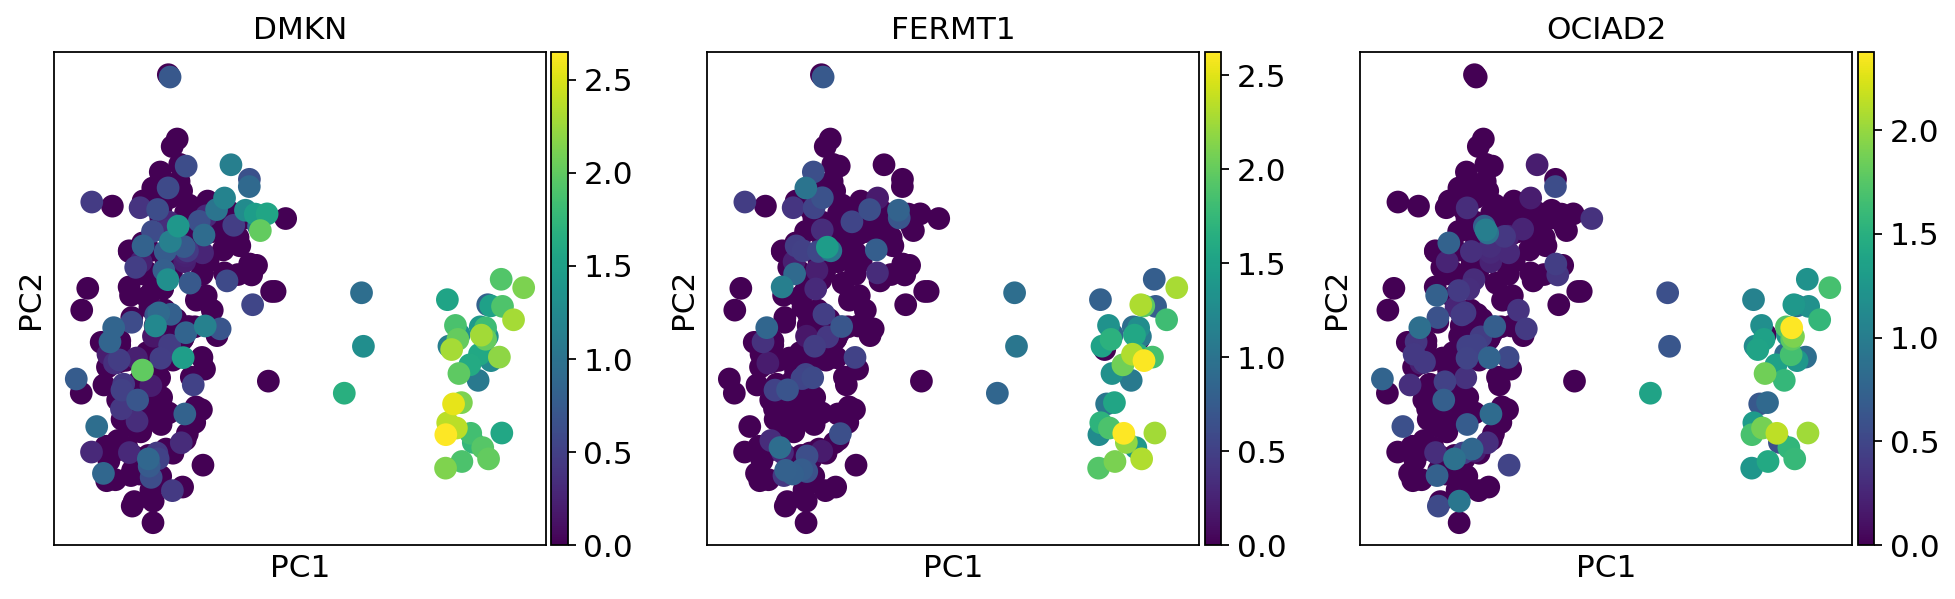

In [72]:
sc.pl.pca(subtype, color = ['DMKN', 'FERMT1', 'OCIAD2',])

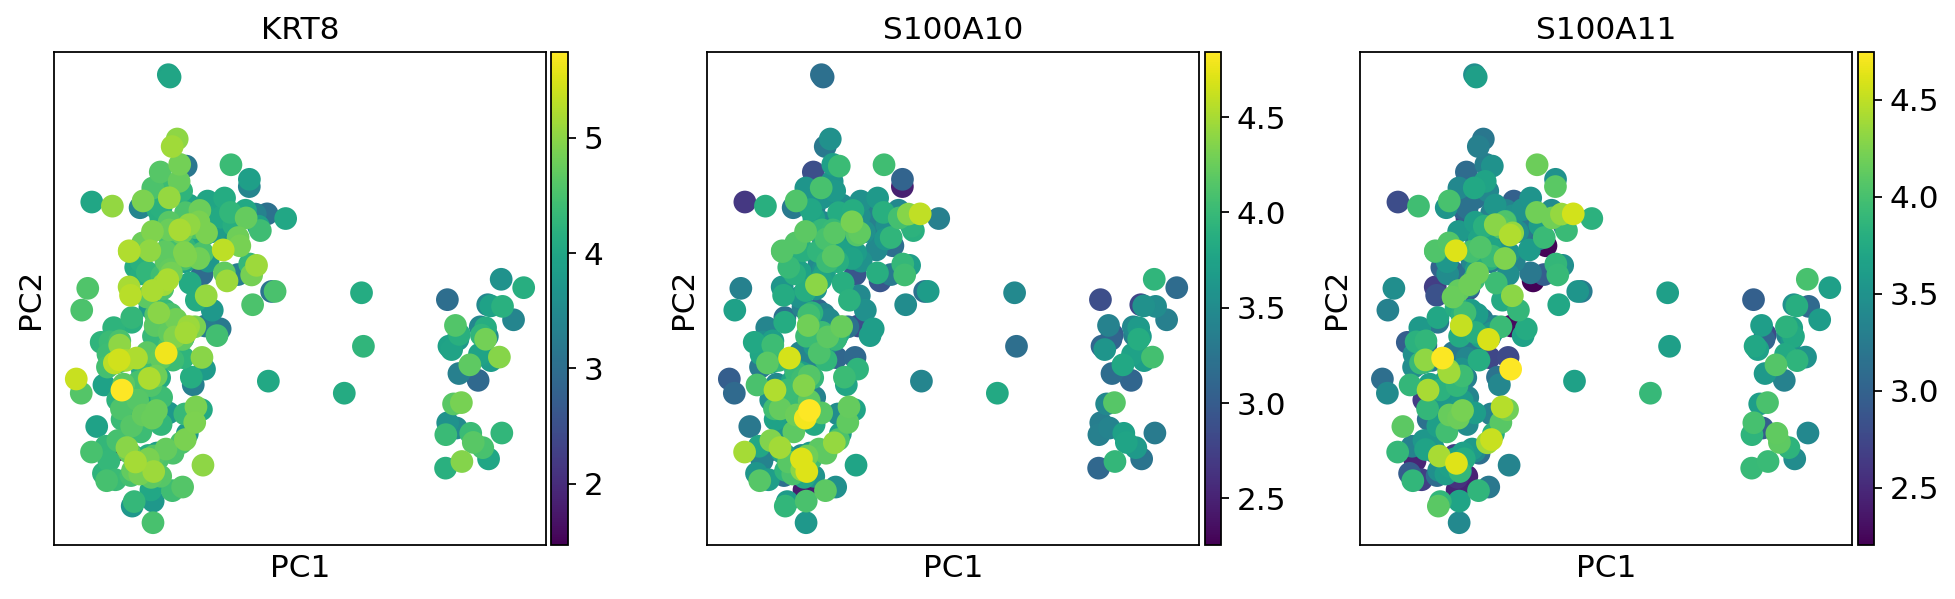

In [71]:
sc.pl.pca(subtype, color = ['KRT8','S100A10','S100A11'])

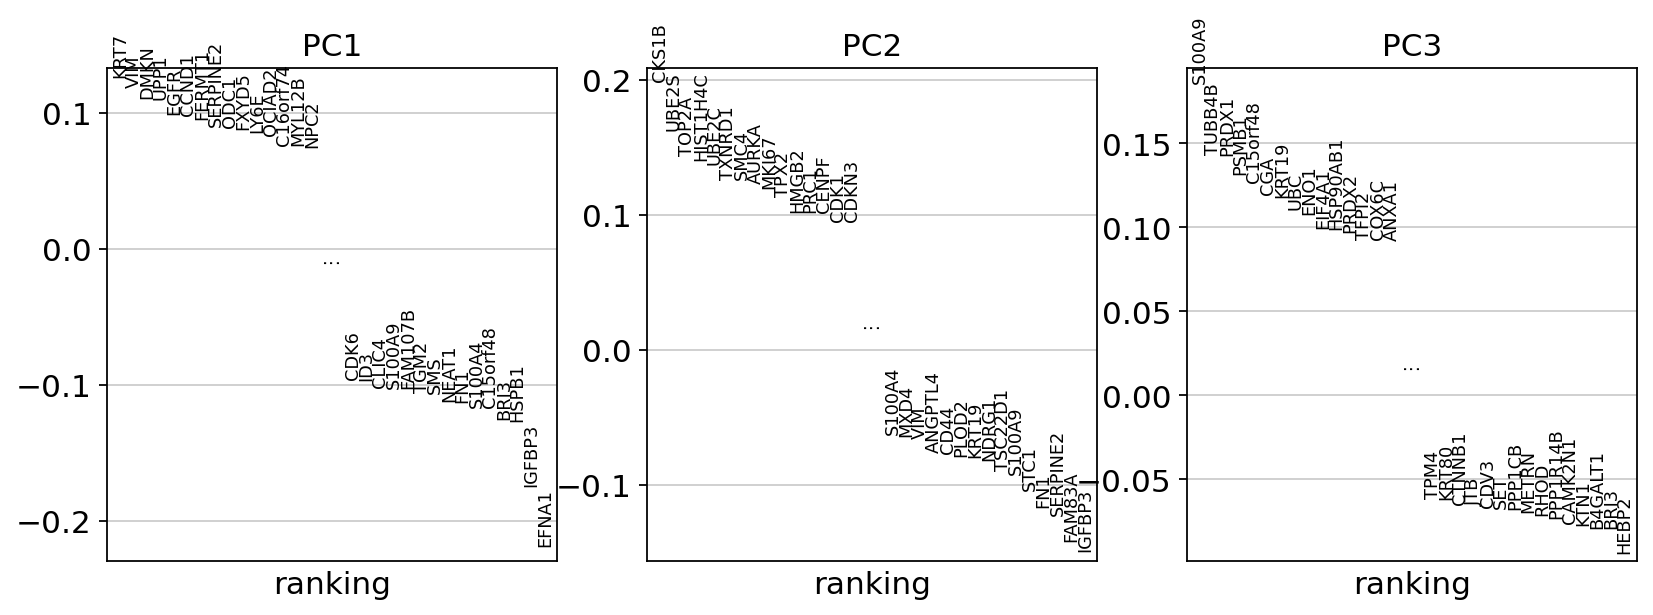

In [67]:
sc.pl.pca_loadings(subtype)

In [79]:
cna = pd.read_csv("cna_test.csv")
cna.index = cna['arm']
cna = cna.drop(columns =['arm']).T.reset_index()

In [104]:
for c in cna.columns[1:]:
    subtype.obs[c] = cna[c].values

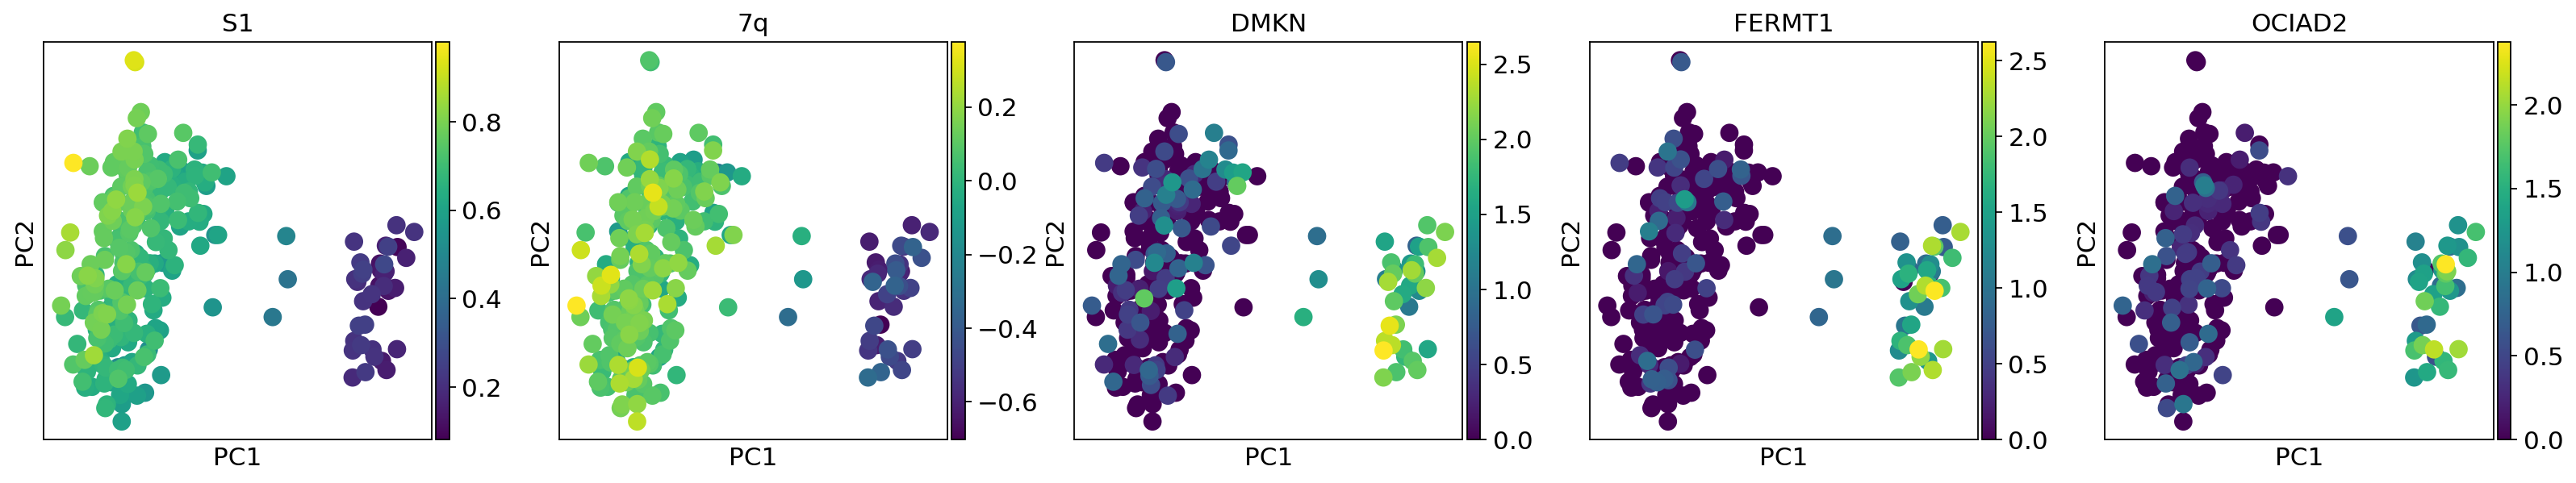

In [159]:
sc.pl.pca(subtype, color = ['S1','7q','DMKN','FERMT1', 'OCIAD2'], ncols = 5)

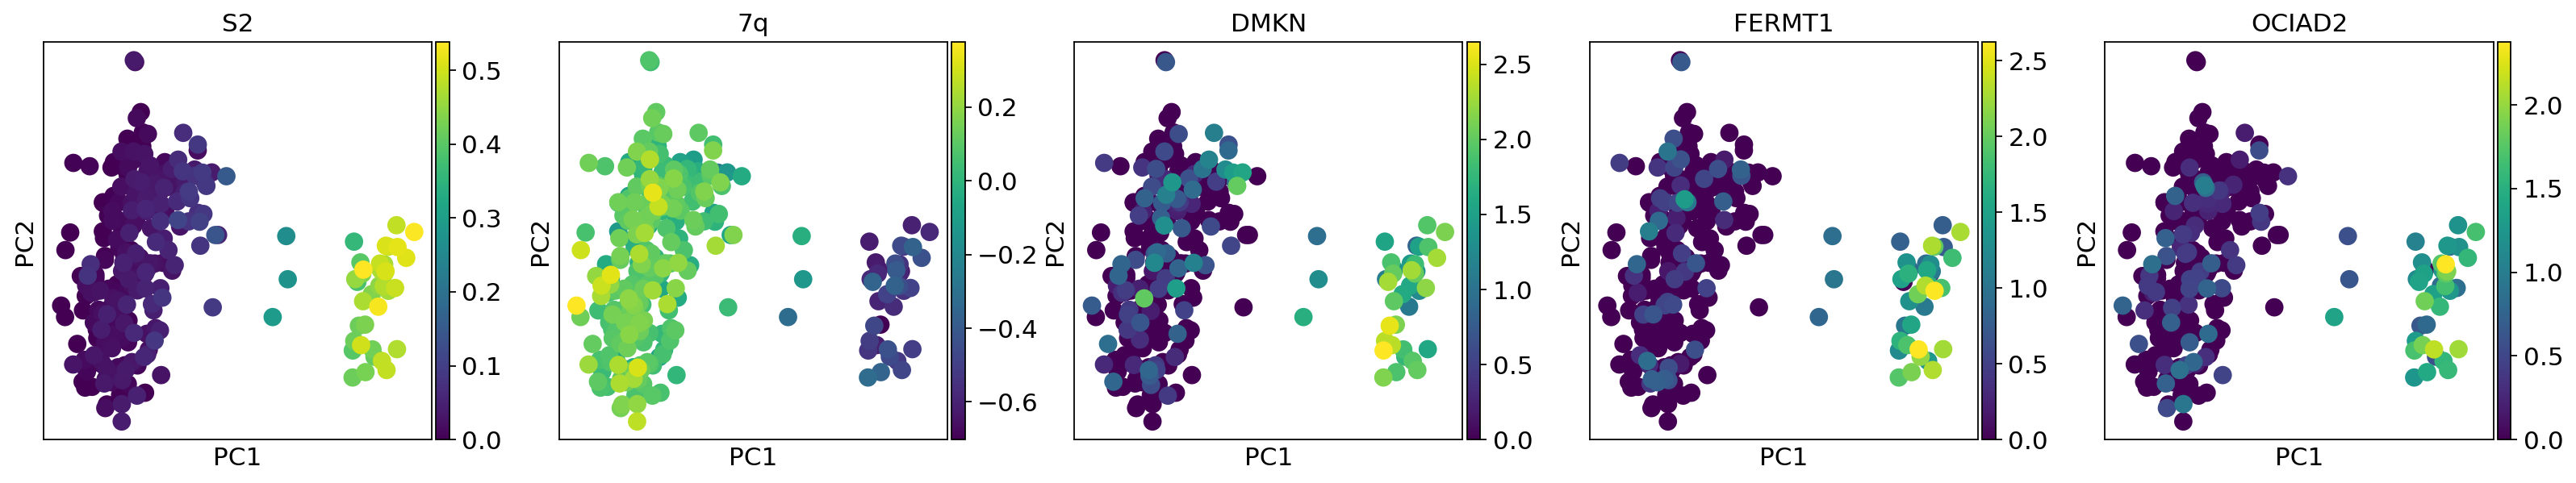

In [109]:
sc.pl.pca(subtype, color = ['S2','7q','DMKN','FERMT1', 'OCIAD2'], ncols = 5)

### Fit Gaussian Mixture model on the copy number state per arm to infer subclones 
compare log likelihood of bimodal vs unimodal gaussian 

In [228]:
from sklearn.mixture import GaussianMixture as GMM

gmm = GMM(n_components=2).fit(subtype.obs[['7q']])
p = gmm.predict(subtype.obs[['7q']])
prob = [p[1] for p in gmm.predict_proba(subtype.obs[['7q']])]

In [236]:
df = pd.DataFrame({'data':subtype.obs['7q'].values, 
                   'GMM classification':p, 
                   'prob':prob})

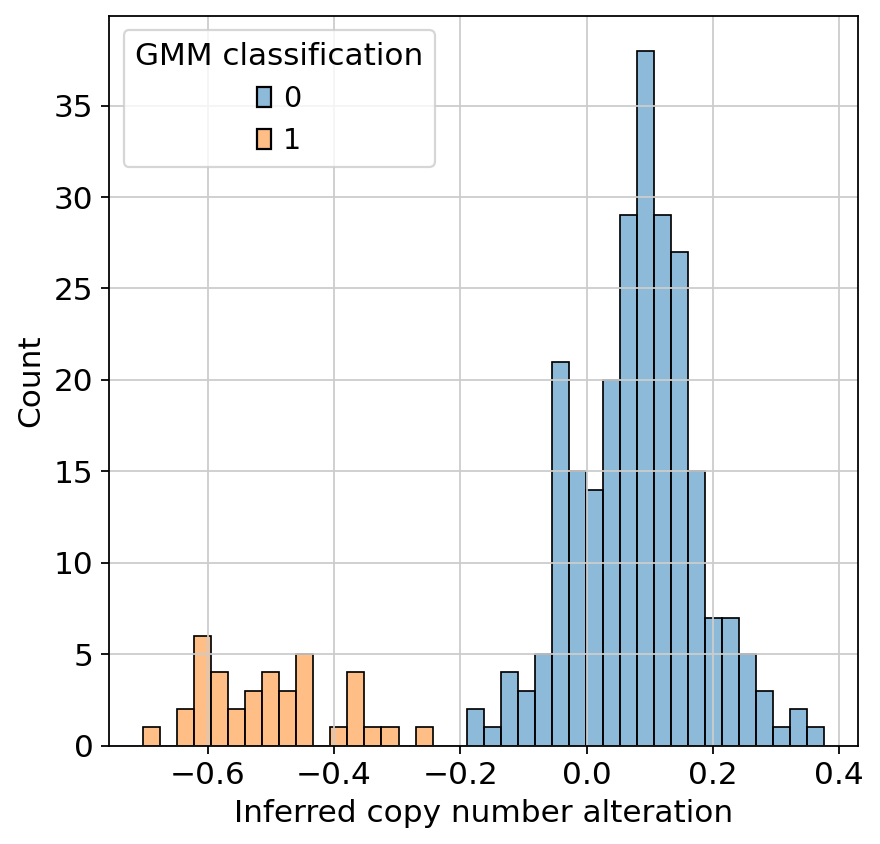

In [240]:
plt.subplots(figsize= (6,6))
sns.histplot(data = df, x= "data", hue = "GMM classification",bins = 40)
plt.xlabel("Inferred copy number alteration")
plt.show()

In [ ]:
plt.hist(data = subtype.obs, x = "7q", bins = 40)
plt.xlabel("Inferred copy number alteration")
plt.ylabel("Counts")


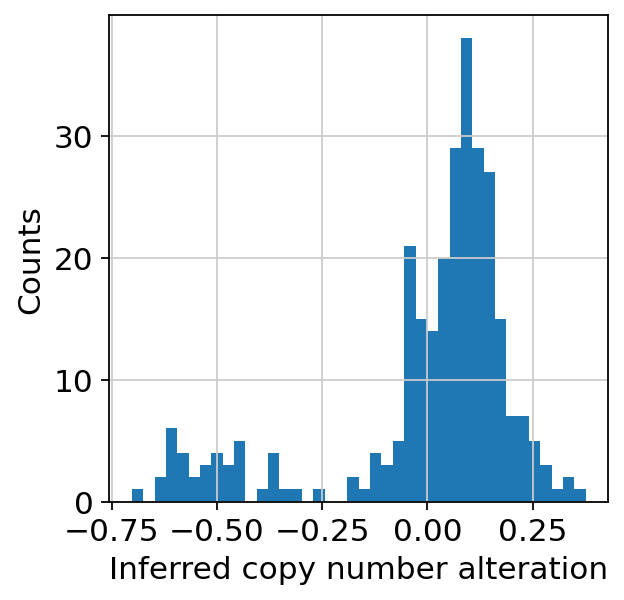

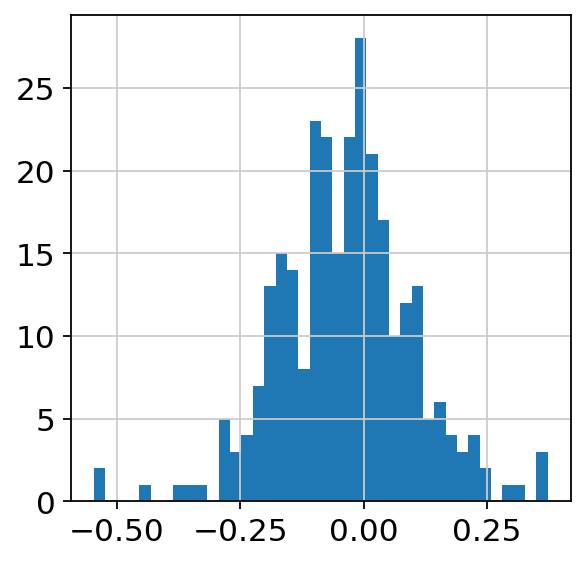

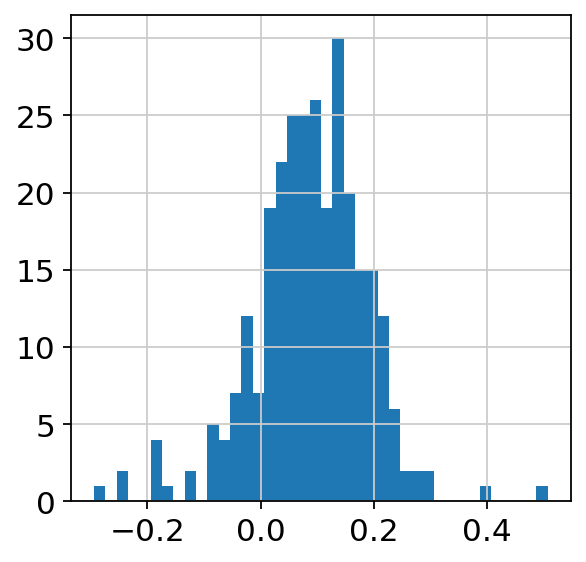

In [162]:
plt.hist(data = subtype.obs, x = "7q", bins = 40)
plt.xlabel("Inferred copy number alteration")
plt.ylabel("Counts")

plt.show()
plt.hist(data = subtype.obs, x = "12p", bins = 40)
plt.show()
plt.hist(data = subtype.obs, x = "12q", bins = 40)
plt.show()

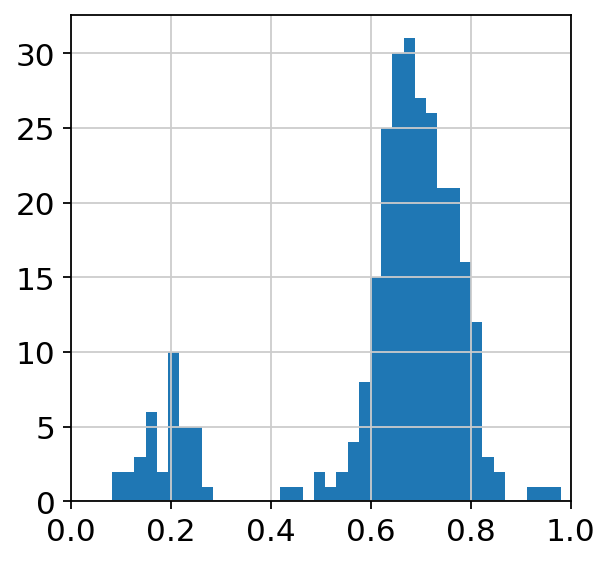

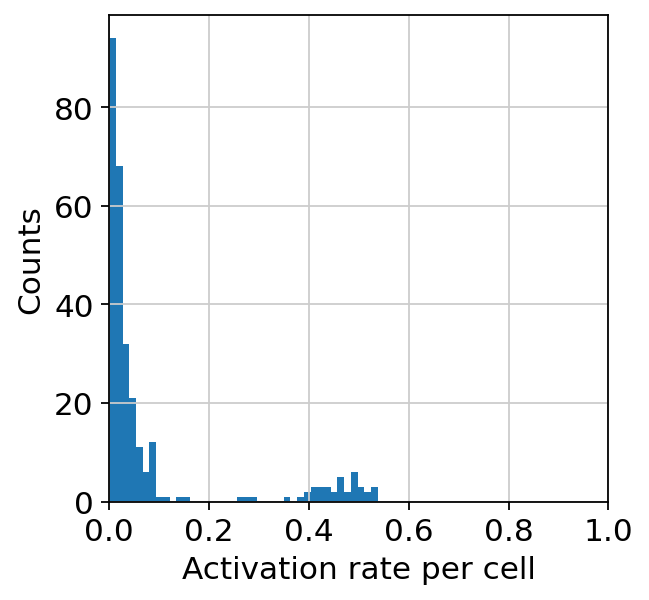

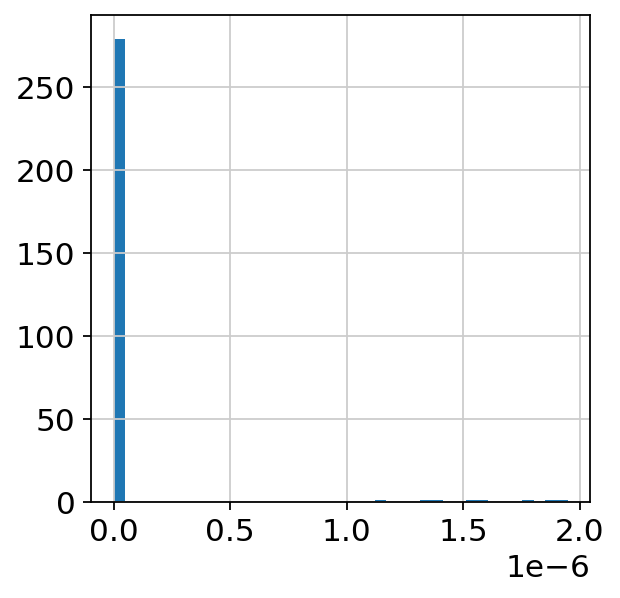

In [164]:
plt.hist(data = subtype.obs, x = "S1", bins = 40)
plt.xlim(0,1)
plt.show()
plt.hist(data = subtype.obs, x = "S2", bins = 40)
plt.xlim(0,1)
plt.xlabel("Activation rate per cell")
plt.ylabel("Counts")
plt.show()
plt.hist(data = subtype.obs, x = "S3", bins = 40)
plt.show()

In [203]:
##d7 = subtype.obs
##w = arm 
def EM_gmm(w,cna,total_iter):

    ###initialize CRS +, CRS- distribution proportion by cell counts at D7
    pi_n0 = 0.5
    pi_e0 = 0.5

    ###initialize normal distritbution parameter per signature by MLE fitting normal distribution on the entire dataset
    mu_0, std_0 = norm.fit(cna[w].values)
    ###initialize exponential distritbution parameter per signature by MLE fitting exp distribution on the entire dataset
#     loc, lambda_0 = expon.fit(d7[f'S{w}'])
#     scale_0 = 0 ###center at 0 (not tuned)

    mu1 = 0
    mu2 = 1
    
    std1 = 4
    std2 = 4
    
    sigma1 = std1**2
    sigma2 = std2**2
    
    pi_n = pi_n0

    data = np.asarray(cna[w].values)
    N = cna.shape[0]

    def calc_rnorm(pi_n, mu, std,x, evidence):

        return (pi_n * norm.pdf(x, mu, std))/evidence

    def log_likelihood(data, mu1, sigma1, mu2, sigma2, pi_n):

        return np.sum( np.log(pi_n * norm.pdf(data, mu1, sigma1**0.5) + (1-pi_n) * norm.pdf(data, mu2, sigma2**0.5) ) )

    pi_tracker, mu1_tracker, sigma1_tracker, mu2_tracker, sigma2_tracker, likelihood_tracker = [],[],[],[],[],[]

    # pi_tracker.append(pi_n)
    # mu_tracker.append(mu)
    # sigma_tracker.append(sigma)
    # lambda_tracker.append(lambda_current)
    # likelihood_tracker.append(log_likelihood(data, mu, sigma, lambda_current, pi_n))
    
    i = 0
    threshold = 1e-50
    
    pi_diff = 1
    mu1_diff = 1
    sigma1_diff = 1
    mu2_diff = 1
    sigma2_diff = 1
    
    
    while i < total_iter and mu1_diff > threshold and mu2_diff > threshold and pi_diff > threshold and sigma1_diff > threshold and  sigma2_diff > threshold: 
        
        ###E step posterior of mixture gaussian and exponential 
        evidence = pi_n * norm.pdf(data, mu1, std1) + (1-pi_n) * norm.pdf(data, mu2, std2) 
        
        r_n = (pi_n * norm.pdf(data, mu1, std1)) / evidence
        #r_e = (1-pi_n) * (expon.pdf(x, scale = lamd)) / evidence

        ### M step - maximize ELBO for mu, sigma, lambda, pi 

        pi_new = np.sum(r_n) / N ###pi_exp = 1-pi_new

        mu1_new = np.sum(data * r_n) /np.sum(r_n)
        sigma1_new = np.sum([(data-mu1_new)**2 * r_n])/np.sum(r_n)
        
        mu2_new = np.sum(data * (1-r_n) ) /np.sum(1-r_n)
        sigma2_new = np.sum([(data-mu2_new)**2 * (1-r_n) ])/np.sum(1-r_n)
       
        
        #convergence check
        mu1_diff = np.linalg.norm(mu1_new - mu1)
        mu2_diff = np.linalg.norm(mu2_new - mu2)
        
        sigma1_diff = np.linalg.norm(sigma1_new - sigma1)
        sigma2_diff = np.linalg.norm(sigma2_new - sigma2)
        
        pi_diff = np.linalg.norm(pi_new - pi_n)
        
        print(mu1_diff, mu2_diff,sigma1_diff , sigma2_diff)
       
        pi_n = pi_new
        mu1 = mu1_new
        sigma1 = sigma1_new
        mu2 = mu2_new
        sigma2 = sigma2_new
        
        likelihood = log_likelihood(data, mu1, sigma1, mu2, sigma2, pi_n)

        pi_tracker.append(pi_n)

        mu1_tracker.append(mu1)
        sigma1_tracker.append(sigma1)
        mu2_tracker.append(mu2)
        sigma2_tracker.append(sigma2)
        
        likelihood_tracker.append(likelihood)

        i+=1
        
    return pi_tracker, mu1_tracker, sigma1_tracker, mu2_tracker, sigma2_tracker, likelihood_tracker

In [193]:
def GMM_diagnostic(w ,pi_tracker, 
                   mu1_tracker,sigma1_tracker, mu2_tracker,sigma2_tracker,likelihood_tracker):
    
    fig,ax = plt.subplots(1,4, figsize = (35,5))

    ax[0].plot(likelihood_tracker)
    ax[0].set_xlabel("Iterations")
    ax[0].set_ylabel("Log likelihood")

    ax[1].plot(pi_tracker, label = "normal proportion")
    ax[1].plot(1- np.asarray(pi_tracker), label = "exponential proportion")

    ax[1].set_xlabel("Iterations")
    ax[1].set_ylabel("% estimate for \n normal/exponential distribution")
    ax[1].legend()

    ax[2].plot(mu1_tracker, label = "mu1 estimate")
    ax[2].plot(mu2_tracker, label = "mu2 estimate")
    
    ax[3].plot(sigma1_tracker, label = "sigma1 estimate")
    ax[3].plot(sigma2_tracker, label = "sigma2 estimate")
    
    ax[2].set_xlabel("Iterations")
    ax[2].set_ylabel("Estimated mu")
    ax[3].set_xlabel("Iterations")
    ax[3].set_ylabel("Estimated sigma")
    
#     ax[4].set_xlabel("Iterations")
#     ax[4].set_ylabel("Estimated lambda")
    
    fig.suptitle(f"GMM for CNA chromosome {w}")

    plt.show()

In [ ]:
def EM_plot(data, w , pi_new, mu, sigma, lambda_current):
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    x = np.linspace(data.min(), data.max(), 100)
    ax.hist(data, bins=50, density=True,color='gray', alpha=0.5, label='histogram of original data')
    ax.plot(x, pi_new * norm(mu, sigma**0.5).pdf(x), color='red', label='Gaussian component')
    ax.plot(x, (1-pi_new) * expon(scale = lambda_current).pdf(x), color='blue', label='Exponential component')
    
#     ax.axvline(x = expon(scale = lambda_current).ppf(0.5), ls = "--", color = "green", label ="50th percentile exponential distribution")
#     ax.axvline(x = norm.ppf(0.5, mu, sigma**0.5), ls = "--", color = "purple",label ="50th percentile normal distribution")

    ax.axvline(x = pi_tracker[-1], color = "green", ls = "--",label = "Inferred classification cut-off")
    
    ax.set_title(f'Gaussian-Exponential mixture EM estimate for S{w}')
    ax.set_xlabel("Activation rate")
    ax.legend()
    lg = ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

    plt.show()

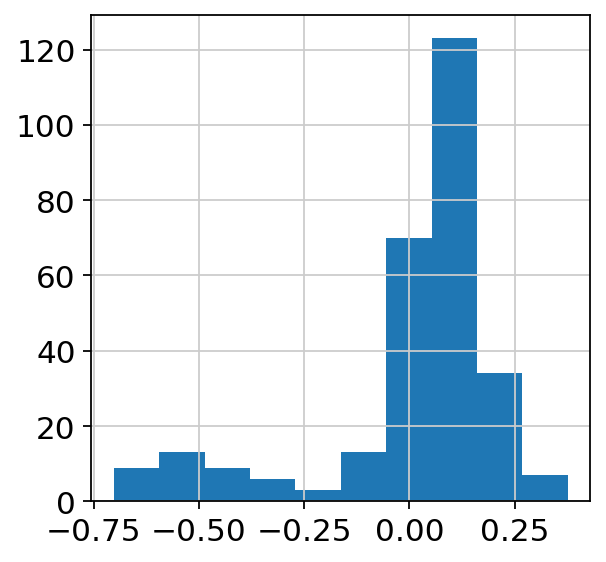

In [214]:
plt.hist(subtype.obs['7q'].values)
plt.show()

In [208]:
EM(w = '7q',d7 = subtype.obs,  total_iter=10000)

([0.6867023426423735, nan],
 [0.06646941800955754, nan],
 [0.01484680857300687, nan],
 [-0.13306815665876429, nan],
 [nan, nan])

In [204]:
pi_tracker, mu1_tracker, sigma1_tracker, mu2_tracker, sigma2_tracker, likelihood_tracker = EM_gmm('7q', subtype.obs,1000)

0.002489026917802844 0.9945333492672723 15.951833678057785 15.952879594164285
0.0014613709117611774 0.001507384485881556 0.000511103194386027 0.0005316978787609783
4.3524796304447375e-06 4.489524353758212e-06 1.5287896885304852e-06 1.5769659897843513e-06
1.2963230914923851e-08 1.3371398798964207e-08 4.553336645229944e-09 4.696706031037667e-09


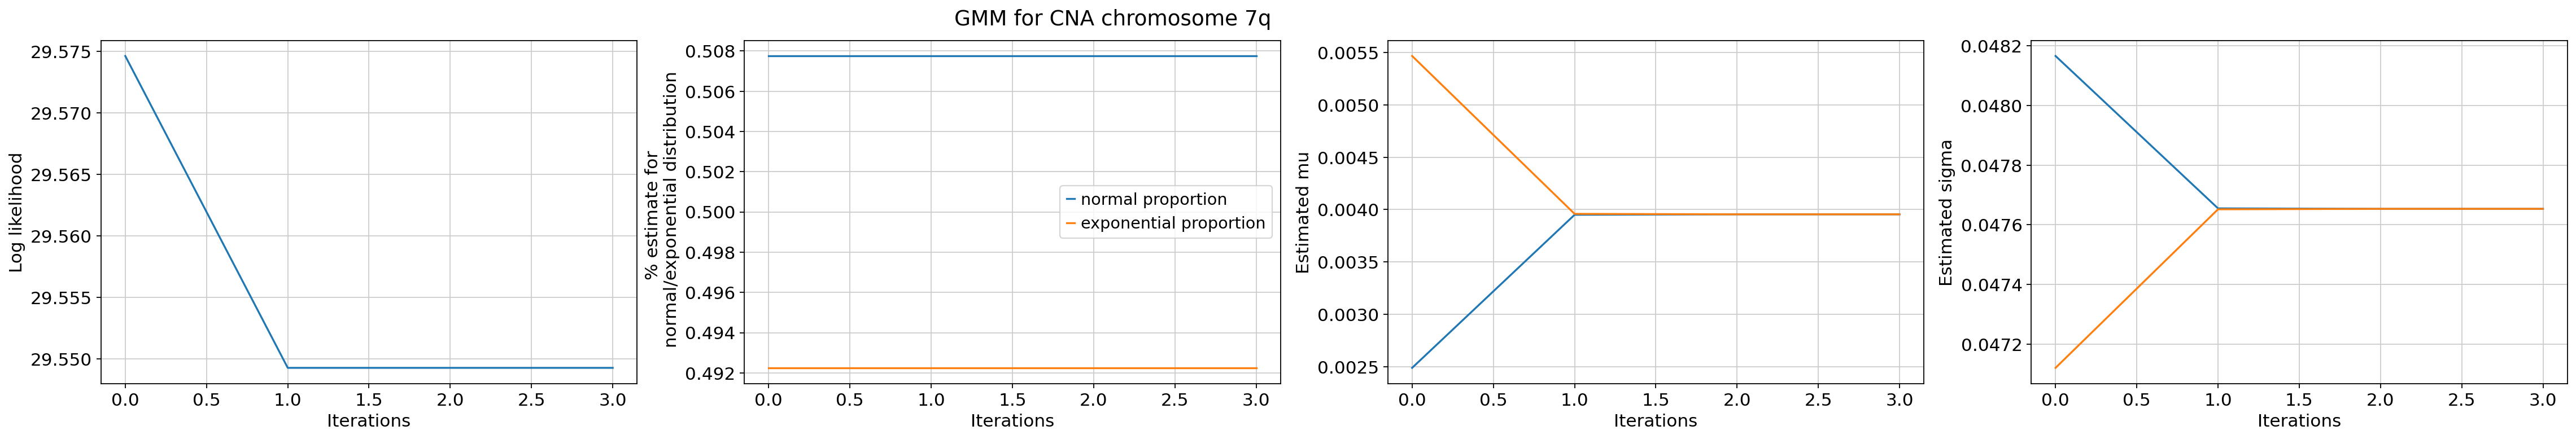

In [206]:
GMM_diagnostic('7q' ,pi_tracker, 
                   mu1_tracker,sigma1_tracker, mu2_tracker,sigma2_tracker,likelihood_tracker)

In [207]:
from scipy.stats import norm, expon

##d7 = subtype.obs
def EM(w,d7,  total_iter):

    ###initialize CRS +, CRS- distribution proportion by cell counts at D7
    pi_n0 = 0.5
    pi_e0 = 0.5

    ###initialize normal distritbution parameter per signature by MLE fitting normal distribution on the entire dataset
    mu_0, std_0 = norm.fit(d7[f'{w}'])
    ###initialize exponential distritbution parameter per signature by MLE fitting exp distribution on the entire dataset
    loc, lambda_0 = expon.fit(d7[f'{w}'])
    scale_0 = 0 ###center at 0 (not tuned)

    mu = mu_0
    std = std_0
    sigma = std**2
    pi_n = pi_n0
    lambda_current = lambda_0

    data = np.asarray(d7[f'{w}'].values)
    N = d7.shape[0]

    def calc_rnorm(pi_n, mu, std,x, evidence):

        return (pi_n * norm.pdf(x, mu, std))/evidence

    def log_likelihood(data, mu, sigma, lambda_current, pi_n):

        return np.sum( np.log(pi_n * norm.pdf(data, mu, sigma**0.5) + (1-pi_n) * expon.pdf(data, loc = loc, scale = lambda_current) ) )

    pi_tracker, mu_tracker, sigma_tracker, lambda_tracker, likelihood_tracker = [],[],[],[],[]

    # pi_tracker.append(pi_n)
    # mu_tracker.append(mu)
    # sigma_tracker.append(sigma)
    # lambda_tracker.append(lambda_current)
    # likelihood_tracker.append(log_likelihood(data, mu, sigma, lambda_current, pi_n))
    
    i = 0
    threshold = 1e-50
    
    pi_diff = 1
    mu_diff = 1
    sigma_diff = 1
    lambda_diff = 1
    
    while i < total_iter and mu_diff > threshold and pi_diff > threshold and sigma_diff > threshold and lambda_diff > threshold:

        ###E step posterior of mixture gaussian and exponential 
        evidence = pi_n * norm.pdf(data, mu, std) + (1-pi_n) * expon.pdf(data, loc =loc, scale = lambda_current)
        r_n = (pi_n * norm.pdf(data, mu, std)) / evidence
        #r_e = (1-pi_n) * (expon.pdf(x, scale = lamd)) / evidence

        ### M step - maximize ELBO for mu, sigma, lambda, pi 

        pi_new = np.sum(r_n) / N ###pi_exp = 1-pi_new

        mu_new = np.sum(data * r_n) /np.sum(r_n)
        #mu_new = np.sum([x*calc_rnorm(x) for x in data])/ np.sum(r_n)
        sigma_new = np.sum([(data-mu_new)**2 * r_n])/np.sum(r_n)
        #sigma_new = np.sum([(x-mu)**2*calc_rnorm(x) for x in data])/np.sum(r_n)

        ###this lambda = scale parameter in exponential function for scipy
        lambda_new = np.sum(data*(1-r_n))/ np.sum(1-r_n)
        #lambda_new = np.sum([x* (1-calc_rnorm(x)) for x in data])/np.sum(1-r_n)
        
        #convergence check
        mu_diff = np.linalg.norm(mu_new - mu)
        pi_diff = np.linalg.norm(pi_new - pi_n)
        sigma_diff = np.linalg.norm(sigma_new - sigma)
        lambda_diff = np.linalg.norm(lambda_new - lambda_current)

        pi_n = pi_new
        mu = mu_new
        sigma = sigma_new
        lambda_current = lambda_new

        likelihood = log_likelihood(data, mu, sigma, lambda_current, pi_n)

        pi_tracker.append(pi_n)
        mu_tracker.append(mu)
        sigma_tracker.append(sigma)
        lambda_tracker.append(lambda_current)
        likelihood_tracker.append(likelihood)

        i+=1
        
    return pi_tracker, mu_tracker,sigma_tracker, lambda_tracker, likelihood_tracker

def EM_diagnostic(w ,pi_tracker, mu_tracker,sigma_tracker, lambda_tracker, likelihood_tracker):
    
    fig,ax = plt.subplots(1,5, figsize = (35,5))

    ax[0].plot(likelihood_tracker)
    ax[0].set_xlabel("Iterations")
    ax[0].set_ylabel("Log likelihood")

    ax[1].plot(pi_tracker, label = "normal proportion")
    ax[1].plot(1- np.asarray(pi_tracker), label = "exponential proportion")

    ax[1].set_xlabel("Iterations")
    ax[1].set_ylabel("% estimate for \n normal/exponential distribution")
    ax[1].legend()

    ax[2].plot(mu_tracker, label = "mu estimate")
    ax[3].plot(sigma_tracker, label = "sigma estimate")
    ax[4].plot(lambda_tracker, label = "lambda estimate")

    ax[2].set_xlabel("Iterations")
    ax[2].set_ylabel("Estimated mu")
    ax[3].set_xlabel("Iterations")
    ax[3].set_ylabel("Estimated sigma")
    ax[4].set_xlabel("Iterations")
    ax[4].set_ylabel("Estimated lambda")
    
    fig.suptitle(f"EM for S{w}")

    plt.show()
    
def EM_plot(data, w , pi_new, mu, sigma, lambda_current):
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    x = np.linspace(data.min(), data.max(), 100)
    ax.hist(data, bins=50, density=True,color='gray', alpha=0.5, label='histogram of original data')
    ax.plot(x, pi_new * norm(mu, sigma**0.5).pdf(x), color='red', label='Gaussian component')
    ax.plot(x, (1-pi_new) * expon(scale = lambda_current).pdf(x), color='blue', label='Exponential component')
    
#     ax.axvline(x = expon(scale = lambda_current).ppf(0.5), ls = "--", color = "green", label ="50th percentile exponential distribution")
#     ax.axvline(x = norm.ppf(0.5, mu, sigma**0.5), ls = "--", color = "purple",label ="50th percentile normal distribution")

    ax.axvline(x = pi_tracker[-1], color = "green", ls = "--",label = "Inferred classification cut-off")
    
    ax.set_title(f'Gaussian-Exponential mixture EM estimate for S{w}')
    ax.set_xlabel("Activation rate")
    ax.legend()
    lg = ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

    plt.show()

In [132]:
pi_tracker, mu_tracker,sigma_tracker, lambda_tracker, likelihood_tracker = EM(2 ,subtype.obs,  100)

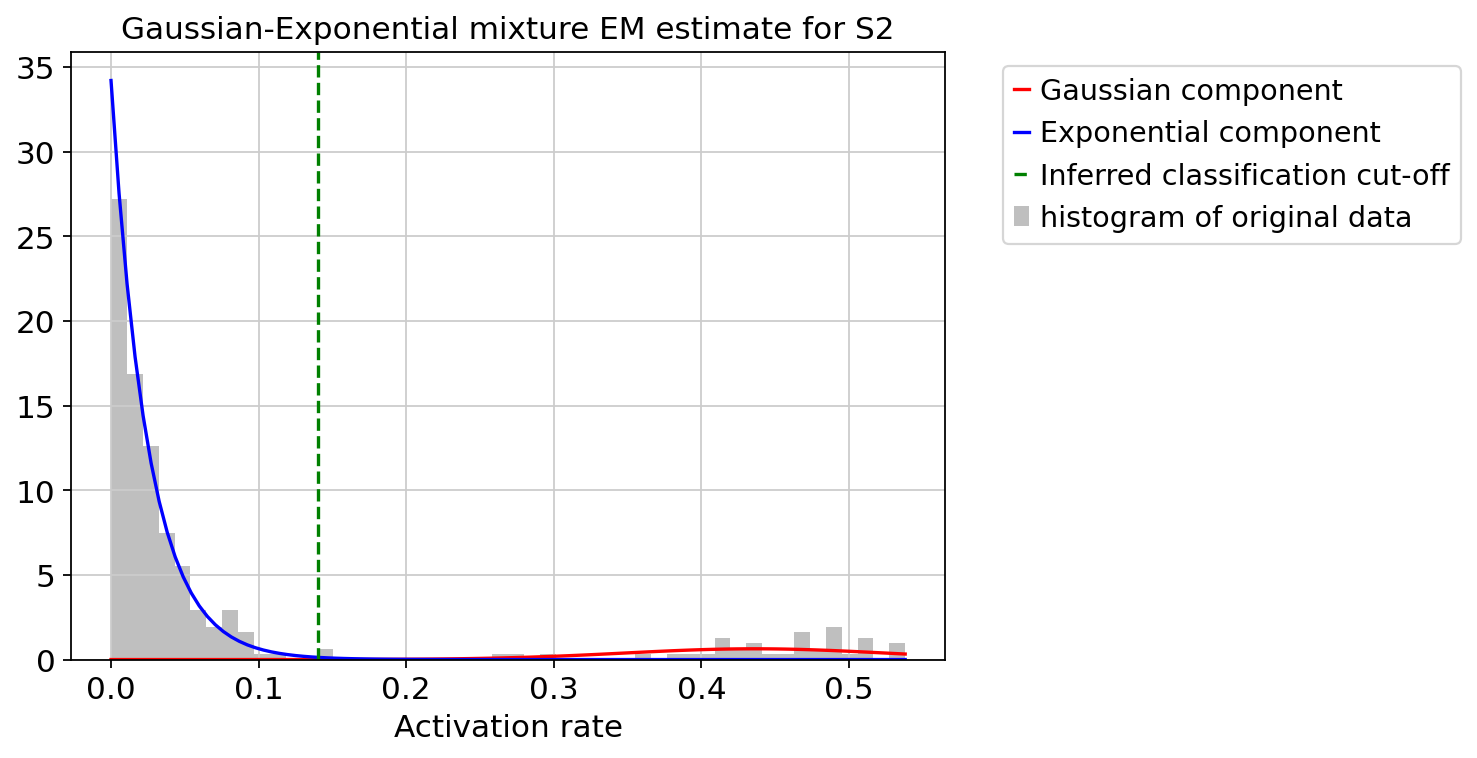

In [173]:
EM_plot(data = subtype.obs['S2'],
        w = 2, 
        pi_new = pi_tracker[-1], 
        mu = mu_tracker[-1], 
        sigma = sigma_tracker[-1], 
        lambda_current = lambda_tracker[-1])

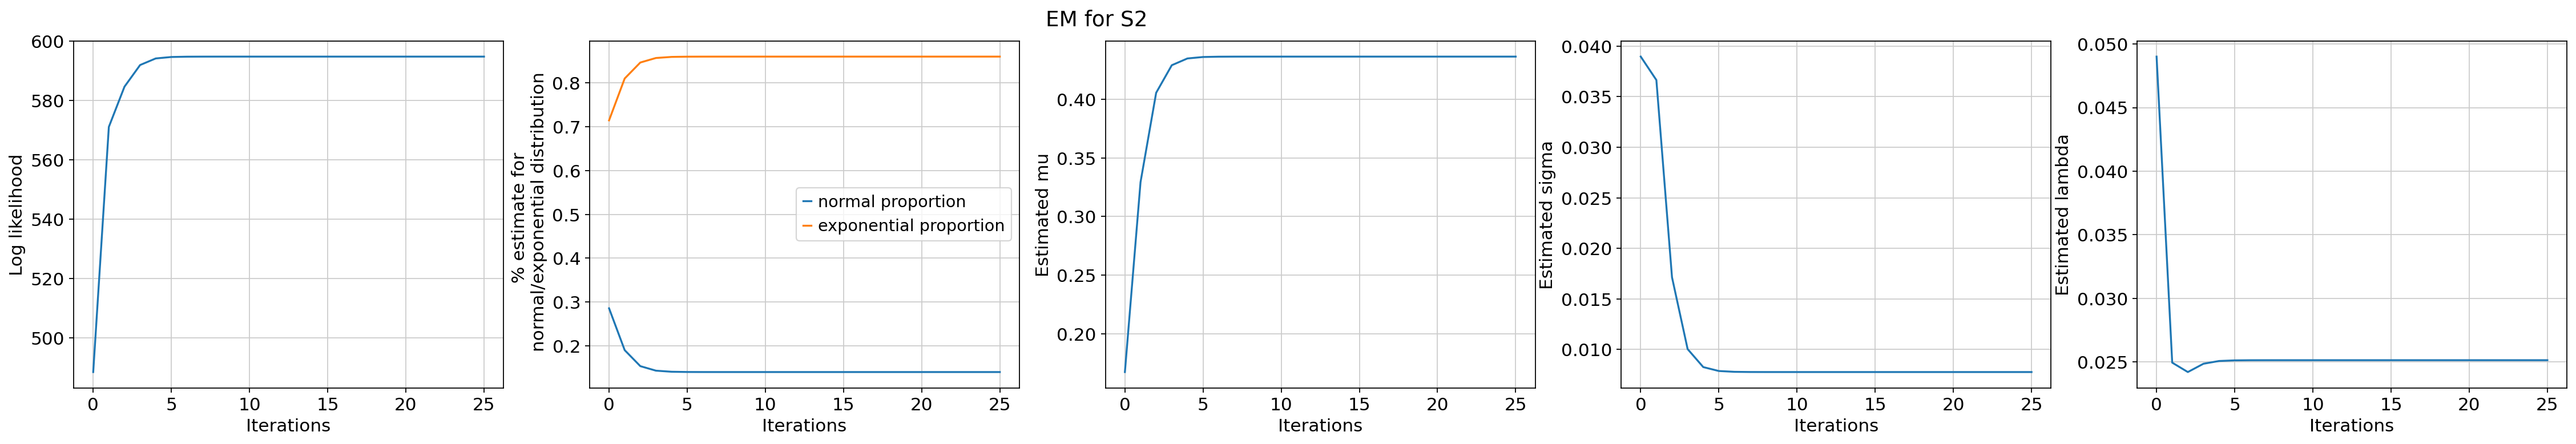

In [140]:
EM_diagnostic(2, pi_tracker, mu_tracker, 
                 sigma_tracker, lambda_tracker, likelihood_tracker)

In [148]:
def em_posterior(w, best_theta):
    
    data = subtype.obs[f'S{w}']
    pi_n, mu, sigma, lambda_current = best_theta
    
    std = sigma**0.5
    loc = 0
    evidence = pi_n * norm.pdf(data, mu, std) + (1-pi_n) * expon.pdf(data, loc =loc, scale = lambda_current)
    r_n = (pi_n * norm.pdf(data, mu, std)) / evidence
    
    subtype.obs[f'S{w}_posterior'] = r_n

In [149]:
em_posterior(w = 2 ,
             best_theta = (pi_tracker[-1], mu_tracker[-1], sigma_tracker[-1], lambda_tracker[-1]))

In [150]:
subtype.obs

,Barcode,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,CCLE_ID,index.1,cancer_type,pool_id,n_cells,...,6p,6q,7p,7q,8p,8q,9p,9q,S1_posterior,S2_posterior
index,,,,,,,,,,,,,,,,,,,,,
NCIH1568_LUNG.AAAGCAAGTCAATACC.11.10,NCIH1568_LUNG.AAAGCAAGTCAATACC.11.10,4357,950061.30,0.0,0.0,NCIH1568_LUNG,NCIH1568_LUNG,Lung Cancer,10,287.0,...,-0.349003,0.048525,0.222916,0.143765,0.198260,0.094602,0.155060,-0.090783,1.000000,3.173414e-07
NCIH1568_LUNG.AACCGCGCACTAAGTC.11.10,NCIH1568_LUNG.AACCGCGCACTAAGTC.11.10,3340,946067.20,0.0,0.0,NCIH1568_LUNG,NCIH1568_LUNG,Lung Cancer,10,287.0,...,-0.095244,0.271957,0.438456,0.114451,0.356023,0.270430,-0.213524,-0.158921,1.000000,5.829579e-07
NCIH1568_LUNG.ACACCCTTCCTTTCTC.11.10,NCIH1568_LUNG.ACACCCTTCCTTTCTC.11.10,4435,945686.70,0.0,0.0,NCIH1568_LUNG,NCIH1568_LUNG,Lung Cancer,10,287.0,...,-0.300296,0.013119,0.200027,-0.045829,-0.030935,-0.096391,-0.017645,-0.099171,1.000000,1.088586e-04
NCIH1568_LUNG.ACATCAGAGGACATTA.11.10,NCIH1568_LUNG.ACATCAGAGGACATTA.11.10,2042,953724.75,0.0,0.0,NCIH1568_LUNG,NCIH1568_LUNG,Lung Cancer,10,287.0,...,-0.023786,0.164071,0.005194,0.195980,0.124411,0.068497,0.031314,-0.220192,1.000000,5.106561e-07
NCIH1568_LUNG.ACATGGTAGGTAGCCA.11.10,NCIH1568_LUNG.ACATGGTAGGTAGCCA.11.10,3621,935367.75,0.0,0.0,NCIH1568_LUNG,NCIH1568_LUNG,Lung Cancer,10,287.0,...,-0.253297,0.370149,0.407420,0.065334,0.023456,0.186369,-0.253738,-0.043484,1.000000,8.969324e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCIH1568_LUNG.TGCTGCTCATGGTCAT.12.10,NCIH1568_LUNG.TGCTGCTCATGGTCAT.12.10,4116,961894.44,0.0,0.0,NCIH1568_LUNG,NCIH1568_LUNG,Lung Cancer,10,287.0,...,-0.113992,0.120865,0.233982,0.094444,-0.054379,0.169377,-0.177714,-0.482192,1.000000,1.327020e-07
NCIH1568_LUNG.TGGACGCGTCTAGGTT.12.10,NCIH1568_LUNG.TGGACGCGTCTAGGTT.12.10,2707,944411.40,0.0,0.0,NCIH1568_LUNG,NCIH1568_LUNG,Lung Cancer,10,287.0,...,-0.266740,0.221031,0.258914,-0.111294,0.015035,0.212674,-0.262366,-0.385313,1.000000,1.627572e-05
NCIH1568_LUNG.TGTATTCGTCCGACGT.12.10,NCIH1568_LUNG.TGTATTCGTCCGACGT.12.10,3909,957157.56,0.0,0.0,NCIH1568_LUNG,NCIH1568_LUNG,Lung Cancer,10,287.0,...,-0.227681,0.160256,0.091340,0.090291,0.308587,0.186805,-0.197630,-0.024323,1.000000,9.513919e-08


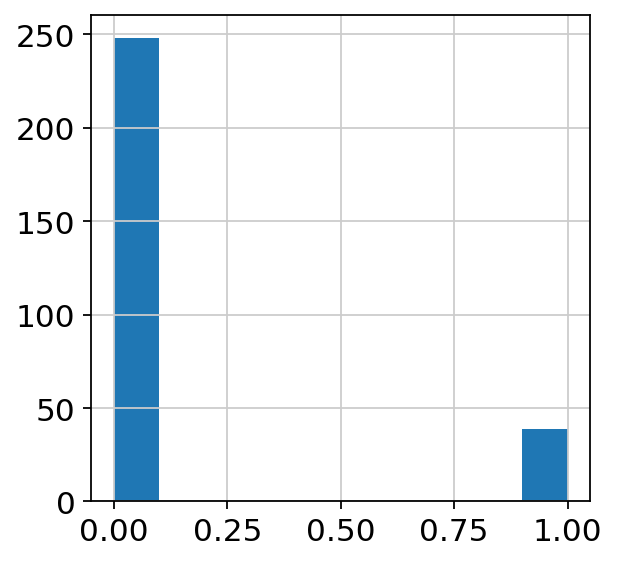

In [151]:
plt.hist(subtype.obs['S2_posterior'])
plt.show()

In [155]:
loc = 0

def log_likelihood(data, mu, sigma, lambda_current, pi_n):

    return np.sum( np.log(pi_n * norm.pdf(data, mu, sigma**0.5) + (1-pi_n) * expon.pdf(data, loc = loc, scale = lambda_current) ) ) 

def null_log_likelihood(data, lambda_current):
    
    return np.sum(np.log (expon.pdf(data, loc = loc, scale = lambda_current)) )

In [157]:
data = subtype.obs['S2']

best_theta = (pi_tracker[-1], mu_tracker[-1], sigma_tracker[-1], lambda_tracker[-1])
pi_n, mu, sigma, lambda_current = best_theta

em_ll = log_likelihood(data, mu, sigma, lambda_current, pi_n)

loc, lambda_current = expon.fit(data)

null_ll = null_log_likelihood(data, lambda_current)

Bayes_factor =  em_ll-null_ll

In [158]:
Bayes_factor

167.07165453659923